# Traffic Volume Forecasting with T-GCN

> Reference: https://github.com/lehaifeng/T-GCN

> Last modified: 7/8/23

# Preparation

In [ ]:
!pip install pytorch-lightning

In [2]:
# import lightning and check the version
import pytorch_lightning as pl
print(pl.__version__)

2.0.6


In [ ]:
!pip install minepy

## Import data

In [4]:
# import libraries

import pandas as pd
import numpy as np
import scipy.io

In [5]:
# download data from UCI archive
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00630/Traffic%20Flow%20Prediction.zip" -O "sample_data/traffic_flow.zip"

--2023-08-07 11:08:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/00630/Traffic%20Flow%20Prediction.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘sample_data/traffic_flow.zip’

sample_data/traffic     [  <=>               ]   4.19M  10.9MB/s    in 0.4s    

2023-08-07 11:08:09 (10.9 MB/s) - ‘sample_data/traffic_flow.zip’ saved [4398563]



In [5]:
# unzip the data
!unzip sample_data/traffic_flow.zip

Archive:  sample_data/traffic_flow.zip
  inflating: Traffic Flow Prediction Dataset.docx  
  inflating: __MACOSX/._Traffic Flow Prediction Dataset.docx  
  inflating: traffic_dataset.mat     
  inflating: __MACOSX/._traffic_dataset.mat  


In [ ]:
#!unzip /*.zip && rm *.zip

## Inspect MAT data

In [6]:
# load the data
traffic_flow_mat = scipy.io.loadmat('traffic_dataset.mat')

In [7]:
sorted(traffic_flow_mat.keys())

['__globals__',
 '__header__',
 '__version__',
 'tra_X_te',
 'tra_X_tr',
 'tra_Y_te',
 'tra_Y_tr',
 'tra_adj_mat']

In [8]:
# extract adjacency matrix that does not need further processing
nvw_adj = traffic_flow_mat['tra_adj_mat']

In [9]:
nvw_adj

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
traffic_flow_mat['tra_X_tr']

array([[<36x48 sparse matrix of type '<class 'numpy.float64'>'
        	with 540 stored elements in Compressed Sparse Column format>,
        <36x48 sparse matrix of type '<class 'numpy.float64'>'
        	with 540 stored elements in Compressed Sparse Column format>,
        <36x48 sparse matrix of type '<class 'numpy.float64'>'
        	with 540 stored elements in Compressed Sparse Column format>,
        ...,
        <36x48 sparse matrix of type '<class 'numpy.float64'>'
        	with 540 stored elements in Compressed Sparse Column format>,
        <36x48 sparse matrix of type '<class 'numpy.float64'>'
        	with 540 stored elements in Compressed Sparse Column format>,
        <36x48 sparse matrix of type '<class 'numpy.float64'>'
        	with 540 stored elements in Compressed Sparse Column format>]],
      dtype=object)

In [13]:
traffic_flow_mat['tra_X_tr'].shape

(1, 1261)

In [17]:
traffic_flow_mat['tra_X_tr'][0][0].toarray().shape

(36, 48)

## Convert data

In [10]:
# convert feature matrices into numpy arrays that can be converted to Torch dataset
def prepare_Xdata(mat_name, var_name):
  "turns csr_matrix into Pandas dataframe, Numpy arrays"
  my_mat = mat_name[var_name]
  my_len = my_mat.shape[1] # number of data instances
  my_list = []

  for i in range(my_len):
    data = my_mat[0][i].toarray().T
    my_list.append(data)
  df_array = np.vstack(my_list)
  my_df = pd.DataFrame(data=df_array)
  return my_df, df_array, np.asarray(my_list)

In [11]:
tra_X_df, tra_X_array, tra_X_shaped = prepare_Xdata(traffic_flow_mat, 'tra_X_tr')

In [12]:
te_X_df, te_X_array, te_X_shaped = prepare_Xdata(traffic_flow_mat, 'tra_X_te')

In [13]:
# visually inspect the data
tra_X_df.head(48)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.092480,0.097151,0.115367,0.112097,0.127043,0.125175,0.144325,0.098552,0.149463,0.182625,...,0.074264,0.043905,0.042504,0.082672,0.106492,0.093414,0.015413,0.067725,0.093881,0.083139
1,0.096684,0.102289,0.110696,0.102756,0.150864,0.142924,0.172816,0.106492,0.161140,0.187763,...,0.064923,0.035965,0.034096,0.067258,0.103690,0.106959,0.027557,0.081738,0.110696,0.066791
2,0.070061,0.081738,0.105558,0.092013,0.131714,0.115834,0.134517,0.089211,0.137319,0.172816,...,0.062121,0.035965,0.023821,0.070528,0.084540,0.084073,0.017749,0.061186,0.088277,0.067258
3,0.065857,0.076600,0.095283,0.083606,0.106025,0.091546,0.106025,0.070995,0.121906,0.159271,...,0.040168,0.033162,0.029426,0.052779,0.064456,0.062121,0.011210,0.045773,0.064923,0.053246
4,0.078468,0.072396,0.067725,0.062121,0.099019,0.094816,0.109762,0.063989,0.126576,0.145726,...,0.044372,0.027090,0.017282,0.049510,0.060252,0.068660,0.014479,0.053246,0.071462,0.046240
5,0.071462,0.067725,0.080336,0.070995,0.090612,0.078468,0.090612,0.047641,0.114433,0.137319,...,0.042036,0.027557,0.027557,0.042971,0.074731,0.071929,0.010276,0.047641,0.070528,0.040635
6,0.054180,0.058851,0.062588,0.053713,0.069127,0.071929,0.078001,0.053713,0.102756,0.134517,...,0.033162,0.025689,0.023354,0.051845,0.045773,0.037366,0.009341,0.033162,0.045773,0.043438
7,0.044372,0.066324,0.061653,0.062588,0.060719,0.053713,0.062588,0.040635,0.109295,0.141523,...,0.026156,0.023354,0.017282,0.041569,0.052779,0.053246,0.009809,0.040168,0.050911,0.028958
8,0.054647,0.059785,0.055582,0.053713,0.060719,0.050911,0.070528,0.042971,0.098085,0.112564,...,0.022419,0.023354,0.018683,0.037366,0.047174,0.041569,0.007940,0.031294,0.049510,0.041102
9,0.050911,0.056983,0.061653,0.066791,0.067258,0.067725,0.076133,0.041102,0.086408,0.108361,...,0.028958,0.020084,0.014946,0.034096,0.034563,0.031761,0.005605,0.028491,0.050911,0.045306


In [14]:
def prepare_ydata(mat_name, var_name):
  "turns csr_matrix into Pandas dataframe"
  my_mat = mat_name[var_name]
  my_len = my_mat.shape[0]
  my_list= []

  for i in range(my_len):
    data = np.expand_dims(my_mat[i], axis=-1)
    my_list.append(data)
  my_array = np.dstack(my_list)

  my_df = pd.DataFrame(data=my_mat.T)

  return my_df, my_mat.T, my_array
  #return my_df, my_array, my_data

In [15]:
tra_y_df, tra_y_array, tra_y_shaped = prepare_ydata(traffic_flow_mat, 'tra_Y_tr')

In [16]:
te_y_df, te_y_array, te_y_shaped = prepare_ydata(traffic_flow_mat, 'tra_Y_te')

In [17]:
tra_y_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.050911,0.046240,0.050444,0.044839,0.044839,0.045306,0.056983,0.043438,0.083139,0.105091,...,0.018216,0.021952,0.014479,0.047174,0.035497,0.031761,0.002802,0.027090,0.034096,0.040635
1,0.047641,0.049510,0.044372,0.038300,0.053246,0.049510,0.064923,0.049043,0.099953,0.130780,...,0.015880,0.021018,0.021018,0.027557,0.028491,0.032228,0.002335,0.018683,0.021952,0.029893
2,0.044839,0.052312,0.050444,0.051378,0.056516,0.049510,0.056049,0.042504,0.088744,0.107426,...,0.020084,0.020551,0.018216,0.054180,0.040635,0.030827,0.000000,0.025689,0.035497,0.056516
3,0.059785,0.046707,0.050444,0.050444,0.049043,0.046707,0.051845,0.035497,0.124241,0.140589,...,0.025222,0.025222,0.013545,0.064923,0.032695,0.032228,0.003737,0.014946,0.024755,0.061186
4,0.062588,0.057450,0.043438,0.045773,0.041569,0.040635,0.046240,0.042036,0.125175,0.134517,...,0.027557,0.024288,0.026156,0.071462,0.029426,0.020551,0.005605,0.014012,0.022887,0.058851


In [18]:
# only extract previous traffic volume time series and ignore other features
def prepare_ts(mat_name, var_name):
  "turns csr_matrix into Pandas dataframe, Numpy arrays"
  my_mat = mat_name[var_name]
  my_len = my_mat.shape[1] # number of data instances
  my_list = []

  for i in range(my_len):
    data = my_mat[0][i].toarray().T
    data = data[2:10,:] #only take the most recent eight previous traffic volume measurements
    my_list.append(data)
  df_array = np.vstack(my_list)
  my_df = pd.DataFrame(data=df_array)
  return my_df, df_array, np.asarray(my_list)

In [19]:
ts_train_df, ts_train_array, ts_train_shaped = prepare_ts(traffic_flow_mat, 'tra_X_tr')

In [20]:
ts_test_df, ts_test_array, ts_test_shaped = prepare_ts(traffic_flow_mat, 'tra_X_te')

In [21]:
# sanity check
ts_train_shaped.shape

(1261, 8, 36)

## Preprocess

Check for null values

In [22]:
tra_X_df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
dtype: int64

In [23]:
te_X_df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
dtype: int64

In [24]:
tra_y_df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
dtype: int64

In [25]:
te_y_df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
dtype: int64

Visually inspect feature distribution

In [26]:
import matplotlib.pyplot as plt

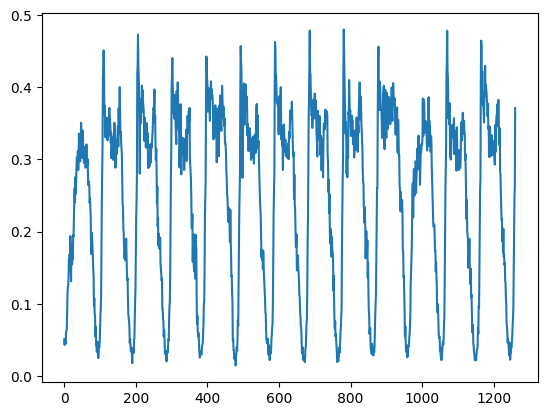

In [27]:
# plot previous traffic volume at time step t-1 for sensor location 0
plt.plot(tra_X_shaped[:,9,0])
plt.show()

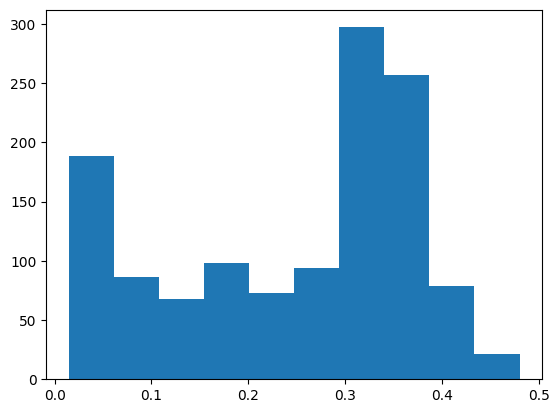

In [28]:
# check the traffic volume distribution for sensor location 0
plt.hist(tra_X_shaped[:,9,0])
plt.show()

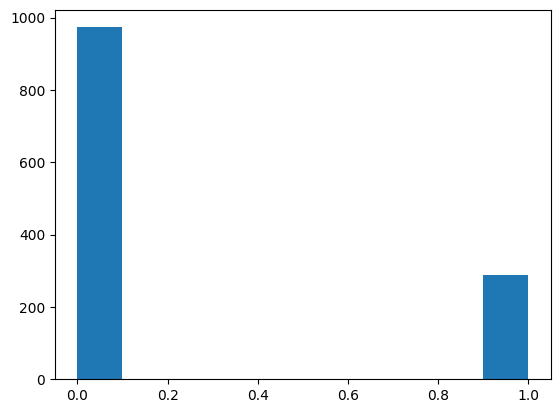

In [29]:
# check one example categorical feature distribution for sensor location 0
plt.hist(tra_X_shaped[:,11,0])
plt.show()

In [30]:
# identify maximum value of feature
max_feat = tra_X_df.max()
max_feat

0     3.0
1     4.0
2     3.0
3     3.0
4     5.0
5     3.0
6     3.0
7     4.0
8     4.0
9     4.0
10    4.0
11    3.0
12    4.0
13    4.0
14    4.0
15    3.0
16    3.0
17    4.0
18    4.0
19    4.0
20    4.0
21    4.0
22    2.0
23    2.0
24    1.0
25    4.0
26    2.0
27    5.0
28    4.0
29    4.0
30    4.0
31    4.0
32    3.0
33    3.0
34    4.0
35    4.0
dtype: float64

In [31]:
# divide by max feat value to normalize the dataset
norm_tra_X_shaped = tra_X_shaped / 5
norm_te_X_shaped = te_X_shaped / 5
norm_tra_y_shaped = tra_y_shaped / 5
norm_te_y_shaped = te_y_shaped / 5

## Feature Engineering

Select important features that have the maximal information coefficient (MIC) above a certain threshold.  

In [42]:
from minepy import pstats, cstats

In [43]:
mic_list = []
for i in zip(tra_X_shaped, tra_y_shaped):
  x,y = i
  # compute statistics between each pair of samples in X and Y
  mic_c, tic_c =  cstats(x, y, alpha=9, c=5, est="mic_e")
  mic_list.append(mic_c)

In [47]:
mic_list[0]

array([[0.7502948 ],
       [0.74740462],
       [0.80566268],
       [0.75003737],
       [0.82978802],
       [0.7502948 ],
       [0.91829583],
       [0.80566268],
       [0.82978802],
       [0.81127812],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.34900395],
       [0.56366892],
       [0.75506702],
       [0.15357769],
       [0.47372054],
       [0.24853523],
       [0.32872772],
       [0.28413714],
       [0.401

In [48]:
mic_array = np.array(mic_list)
mic_array.shape

(1261, 48, 1)

In [54]:
mean_mic_array = np.mean(mic_array, axis=0)

In [55]:
np.argwhere(mean_mic_array>0.7)

array([[2, 0],
       [3, 0],
       [4, 0],
       [5, 0],
       [6, 0],
       [7, 0],
       [8, 0],
       [9, 0]])

# Modeling

In [3]:
# import libraries

import torch
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
import scipy.sparse as sp
import matplotlib.pyplot as plt
import copy
from pytorch_lightning.utilities import rank_zero_warn
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
import argparse
import torch.optim
import torch.nn.functional as F
import torchmetrics

## Prepare Lightning DataModule

Prepare Torch Datasets

In [33]:
train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(tra_X_shaped), torch.FloatTensor(tra_y_shaped)
    )
test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(te_X_shaped), torch.FloatTensor(te_y_shaped)
    )

In [34]:
ts_train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(ts_train_shaped), torch.FloatTensor(tra_y_shaped)
    )
ts_test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(ts_test_shaped), torch.FloatTensor(te_y_shaped)
    )

In [35]:
# use 20% of training data for validation
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size

In [36]:
class TrafficDataModule(pl.LightningDataModule):
    def __init__(self, feat_mode:str = "tells which feat to use"):
        super().__init__()
        self.feat_mode = feat_mode

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            if self.feat_mode == "all":
              traffic_full = train_dataset
            elif self.feat_mode == "ts":
              traffic_full = ts_train_dataset
            self.traffic_train = data.Subset(traffic_full, range(train_set_size))
            self.traffic_val = data.Subset(traffic_full, range(train_set_size, len(traffic_full)))

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            if self.feat_mode == "all":
              self.traffic_test = test_dataset
            elif self.feat_mode == "ts":
              self.traffic_test = ts_test_dataset

    def train_dataloader(self):
        return DataLoader(self.traffic_train, batch_size=32, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.traffic_val, batch_size=32, drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.traffic_test, batch_size=len(self.traffic_test))

## Define a model

### GRU

In [37]:
class GRULinear(nn.Module):
    def __init__(self, num_gru_units: int, output_dim: int, bias: float = 0.0):
        super(GRULinear, self).__init__()
        self._num_gru_units = num_gru_units
        self._output_dim = output_dim
        self._bias_init_value = bias
        self.weights = nn.Parameter(
            torch.FloatTensor(self._num_gru_units + 1, self._output_dim)
        )
        self.biases = nn.Parameter(torch.FloatTensor(self._output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weights)
        nn.init.constant_(self.biases, self._bias_init_value)

    def forward(self, inputs, hidden_state):
        batch_size, num_nodes = inputs.shape
        # inputs (batch_size, num_nodes, 1)
        inputs = inputs.reshape((batch_size, num_nodes, 1))
        # hidden_state (batch_size, num_nodes, num_gru_units)
        hidden_state = hidden_state.reshape(
            (batch_size, num_nodes, self._num_gru_units)
        )
        # [inputs, hidden_state] "[x, h]" (batch_size, num_nodes, num_gru_units + 1)
        concatenation = torch.cat((inputs, hidden_state), dim=2)
        # [x, h] (batch_size * num_nodes, gru_units + 1)
        concatenation = concatenation.reshape((-1, self._num_gru_units + 1))
        # [x, h]W + b (batch_size * num_nodes, output_dim)
        outputs = concatenation @ self.weights + self.biases
        # [x, h]W + b (batch_size, num_nodes, output_dim)
        outputs = outputs.reshape((batch_size, num_nodes, self._output_dim))
        # [x, h]W + b (batch_size, num_nodes * output_dim)
        outputs = outputs.reshape((batch_size, num_nodes * self._output_dim))
        return outputs

    def hyperparameters(self):
        return {
            "num_gru_units": self._num_gru_units,
            "output_dim": self._output_dim,
            "bias_init_value": self._bias_init_value,
        }


class GRUCell(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super(GRUCell, self).__init__()
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        self.linear1 = GRULinear(self._hidden_dim, self._hidden_dim * 2, bias=1.0)
        self.linear2 = GRULinear(self._hidden_dim, self._hidden_dim)

    def forward(self, inputs, hidden_state):
        # [r, u] = sigmoid([x, h]W + b)
        # [r, u] (batch_size, num_nodes * (2 * num_gru_units))
        concatenation = torch.sigmoid(self.linear1(inputs, hidden_state))
        # r (batch_size, num_nodes * num_gru_units)
        # u (batch_size, num_nodes * num_gru_units)
        r, u = torch.chunk(concatenation, chunks=2, dim=1)
        # c = tanh([x, (r * h)]W + b)
        # c (batch_size, num_nodes * num_gru_units)
        c = torch.tanh(self.linear2(inputs, r * hidden_state))
        # h := u * h + (1 - u) * c
        # h (batch_size, num_nodes * num_gru_units)
        new_hidden_state = u * hidden_state + (1 - u) * c
        return new_hidden_state, new_hidden_state

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}


class GRU(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, **kwargs):
        super(GRU, self).__init__()
        self._input_dim = input_dim  # num_nodes for prediction
        self._hidden_dim = hidden_dim
        self.gru_cell = GRUCell(self._input_dim, self._hidden_dim)

    def forward(self, inputs):
        batch_size, seq_len, num_nodes = inputs.shape
        assert self._input_dim == num_nodes
        outputs = list()
        hidden_state = torch.zeros(batch_size, num_nodes * self._hidden_dim).type_as(
            inputs
        )
        for i in range(seq_len):
            output, hidden_state = self.gru_cell(inputs[:, i, :], hidden_state)
            output = output.reshape((batch_size, num_nodes, self._hidden_dim))
            outputs.append(output)
        last_output = outputs[-1]
        return last_output

    @staticmethod
    def add_model_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--hidden_dim", type=int, default=64)
        return parser

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}

### GCN

In [38]:
# helper function for GCN
def calculate_laplacian_with_self_loop(matrix):
    matrix = matrix + torch.eye(matrix.size(0))
    row_sum = matrix.sum(1)
    d_inv_sqrt = torch.pow(row_sum, -0.5).flatten()
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
    d_mat_inv_sqrt = torch.diag(d_inv_sqrt)
    normalized_laplacian = (
        matrix.matmul(d_mat_inv_sqrt).transpose(0, 1).matmul(d_mat_inv_sqrt)
    )
    return normalized_laplacian

In [39]:
class GCN(nn.Module):
    def __init__(self, adj, input_dim: int, output_dim: int, **kwargs):
        super(GCN, self).__init__()
        self.register_buffer(
            "laplacian", calculate_laplacian_with_self_loop(torch.FloatTensor(adj))
        )
        self._num_nodes = adj.shape[0]
        self._input_dim = input_dim  # seq_len for prediction
        self._output_dim = output_dim  # hidden_dim for prediction
        self.weights = nn.Parameter(
            torch.FloatTensor(self._input_dim, self._output_dim)
        )
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weights, gain=nn.init.calculate_gain("tanh"))

    def forward(self, inputs):
        # (batch_size, seq_len, num_nodes)
        batch_size = inputs.shape[0]
        # (num_nodes, batch_size, seq_len)
        inputs = inputs.transpose(0, 2).transpose(1, 2)
        # (num_nodes, batch_size * seq_len)
        inputs = inputs.reshape((self._num_nodes, batch_size * self._input_dim))
        # AX (num_nodes, batch_size * seq_len)
        ax = self.laplacian @ inputs
        # (num_nodes, batch_size, seq_len)
        ax = ax.reshape((self._num_nodes, batch_size, self._input_dim))
        # (num_nodes * batch_size, seq_len)
        ax = ax.reshape((self._num_nodes * batch_size, self._input_dim))
        # act(AXW) (num_nodes * batch_size, output_dim)
        outputs = torch.tanh(ax @ self.weights)
        # (num_nodes, batch_size, output_dim)
        outputs = outputs.reshape((self._num_nodes, batch_size, self._output_dim))
        # (batch_size, num_nodes, output_dim)
        outputs = outputs.transpose(0, 1)
        return outputs

    @staticmethod
    def add_model_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--hidden_dim", type=int, default=64)
        return parser

    @property
    def hyperparameters(self):
        return {
            "num_nodes": self._num_nodes,
            "input_dim": self._input_dim,
            "output_dim": self._output_dim,
        }

### T-GCN

In [40]:
class TGCNGraphConvolution(nn.Module):
    def __init__(self, adj, num_gru_units: int, output_dim: int, bias: float = 0.0):
        super(TGCNGraphConvolution, self).__init__()
        self._num_gru_units = num_gru_units
        self._output_dim = output_dim
        self._bias_init_value = bias
        self.register_buffer(
            "laplacian", calculate_laplacian_with_self_loop(torch.FloatTensor(adj))
        )
        self.weights = nn.Parameter(
            torch.FloatTensor(self._num_gru_units + 1, self._output_dim)
        )
        self.biases = nn.Parameter(torch.FloatTensor(self._output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weights)
        nn.init.constant_(self.biases, self._bias_init_value)

    def forward(self, inputs, hidden_state):
        batch_size, num_nodes = inputs.shape
        # inputs (batch_size, num_nodes) -> (batch_size, num_nodes, 1)
        inputs = inputs.reshape((batch_size, num_nodes, 1))
        # hidden_state (batch_size, num_nodes, num_gru_units)
        hidden_state = hidden_state.reshape(
            (batch_size, num_nodes, self._num_gru_units)
        )
        # [x, h] (batch_size, num_nodes, num_gru_units + 1)
        concatenation = torch.cat((inputs, hidden_state), dim=2)
        # [x, h] (num_nodes, num_gru_units + 1, batch_size)
        concatenation = concatenation.transpose(0, 1).transpose(1, 2)
        # [x, h] (num_nodes, (num_gru_units + 1) * batch_size)
        concatenation = concatenation.reshape(
            (num_nodes, (self._num_gru_units + 1) * batch_size)
        )
        # A[x, h] (num_nodes, (num_gru_units + 1) * batch_size)
        a_times_concat = self.laplacian @ concatenation
        # A[x, h] (num_nodes, num_gru_units + 1, batch_size)
        a_times_concat = a_times_concat.reshape(
            (num_nodes, self._num_gru_units + 1, batch_size)
        )
        # A[x, h] (batch_size, num_nodes, num_gru_units + 1)
        a_times_concat = a_times_concat.transpose(0, 2).transpose(1, 2)
        # A[x, h] (batch_size * num_nodes, num_gru_units + 1)
        a_times_concat = a_times_concat.reshape(
            (batch_size * num_nodes, self._num_gru_units + 1)
        )
        # A[x, h]W + b (batch_size * num_nodes, output_dim)
        outputs = a_times_concat @ self.weights + self.biases
        # A[x, h]W + b (batch_size, num_nodes, output_dim)
        outputs = outputs.reshape((batch_size, num_nodes, self._output_dim))
        # A[x, h]W + b (batch_size, num_nodes * output_dim)
        outputs = outputs.reshape((batch_size, num_nodes * self._output_dim))
        return outputs

    @property
    def hyperparameters(self):
        return {
            "num_gru_units": self._num_gru_units,
            "output_dim": self._output_dim,
            "bias_init_value": self._bias_init_value,
        }


class TGCNCell(nn.Module):
    def __init__(self, adj, input_dim: int, hidden_dim: int):
        super(TGCNCell, self).__init__()
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.graph_conv1 = TGCNGraphConvolution(
            self.adj, self._hidden_dim, self._hidden_dim * 2, bias=1.0
        )
        self.graph_conv2 = TGCNGraphConvolution(
            self.adj, self._hidden_dim, self._hidden_dim
        )

    def forward(self, inputs, hidden_state):
        # [r, u] = sigmoid(A[x, h]W + b)
        # [r, u] (batch_size, num_nodes * (2 * num_gru_units))
        concatenation = torch.sigmoid(self.graph_conv1(inputs, hidden_state))
        # r (batch_size, num_nodes, num_gru_units)
        # u (batch_size, num_nodes, num_gru_units)
        r, u = torch.chunk(concatenation, chunks=2, dim=1)
        # c = tanh(A[x, (r * h)W + b])
        # c (batch_size, num_nodes * num_gru_units)
        c = torch.tanh(self.graph_conv2(inputs, r * hidden_state))
        # h := u * h + (1 - u) * c
        # h (batch_size, num_nodes * num_gru_units)
        new_hidden_state = u * hidden_state + (1.0 - u) * c
        return new_hidden_state, new_hidden_state

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}

class TGCN(nn.Module):
    def __init__(self, adj, hidden_dim: int, **kwargs):
        super(TGCN, self).__init__()
        self._input_dim = adj.shape[0]
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.tgcn_cell = TGCNCell(self.adj, self._input_dim, self._hidden_dim)

    def forward(self, inputs):
        batch_size, seq_len, num_nodes = inputs.shape
        assert self._input_dim == num_nodes
        hidden_state = torch.zeros(batch_size, num_nodes * self._hidden_dim).type_as(
            inputs
        )
        output = None
        for i in range(seq_len):
            output, hidden_state = self.tgcn_cell(inputs[:, i, :], hidden_state)
            output = output.reshape((batch_size, num_nodes, self._hidden_dim))
        return output
        # for multivariate feature input
        # output, hidden_state = self.tgcn_cell(inputs, hidden_state)
        # output = output.reshape((batch_size, num_nodes, self._hidden_dim))
        # return output

    @staticmethod
    def add_model_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--hidden_dim", type=int, default=64)
        return parser

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}

## Define a PyTorch Lightning Module

Loss and evaluation metrics

In [41]:
def my_r2(pred, y):
    """
    :param y: ground truth
    :param pred: predictions
    :return: R square (coefficient of determination)
    """
    return 1 - torch.sum((y - pred) ** 2) / torch.sum((y - torch.mean(pred)) ** 2)

def my_explained_variance(pred, y):
    return 1 - torch.var(y - pred) / torch.var(y)

In [42]:
class SupervisedForecastTask(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        regressor="linear",
        loss="mse",
        pre_len: int = 1,
        learning_rate: float = 1e-3,
        weight_decay: float = 1.5e-3,
        feat_max_val: float = 1.0,
        **kwargs
    ):
        super(SupervisedForecastTask, self).__init__()
        self.save_hyperparameters()
        self.model = model
        self.regressor = (
            nn.Linear(
                self.model.hyperparameters.get("hidden_dim")
                or self.model.hyperparameters.get("output_dim"),
                self.hparams.pre_len,
            )
            if regressor == "linear"
            else regressor
        )
        self._loss = loss
        self.feat_max_val = feat_max_val

    def forward(self, x):
        # (batch_size, seq_len, num_nodes)
        batch_size, _, num_nodes = x.size()
        # (batch_size, num_nodes, hidden_dim)
        hidden = self.model(x)
        # (batch_size * num_nodes, hidden_dim)
        hidden = hidden.reshape((-1, hidden.size(2)))
        # (batch_size * num_nodes, pre_len)
        if self.regressor is not None:
            predictions = self.regressor(hidden)
        else:
            predictions = hidden
        predictions = predictions.reshape((batch_size, num_nodes, -1))
        return predictions

    def shared_step(self, batch, batch_idx):
        # (batch_size, seq_len/pre_len, num_nodes)
        x, y = batch
        num_nodes = x.size(2)
        predictions = self(x)
        predictions = predictions.transpose(1, 2).reshape((-1, num_nodes))
        y = y.reshape((-1, y.size(2)))
        return predictions, y

    def loss(self, inputs, targets):
        return F.mse_loss(inputs, targets)

    def training_step(self, batch, batch_idx):
        predictions, y = self.shared_step(batch, batch_idx)
        loss = self.loss(predictions, y)
        self.log('step', self.trainer.current_epoch, on_step=False, on_epoch=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_validation_epoch_start(self):
        self.validation_step_preds = []
        self.validation_step_targets = []

    def validation_step(self, batch, batch_idx):
        predictions, y = self.shared_step(batch, batch_idx)
        predictions = predictions * self.feat_max_val
        y = y * self.feat_max_val
        self.validation_step_preds.append(predictions.cpu())
        self.validation_step_targets.append(y.cpu())
        loss = self.loss(predictions, y)
        rmse = torch.sqrt(torchmetrics.functional.mean_squared_error(predictions, y))
        mae = torchmetrics.functional.mean_absolute_error(predictions, y)
        r2 = my_r2(predictions, y)
        explained_variance = my_explained_variance(predictions, y)
        metrics = {
            "val_loss": loss,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "ExplainedVar": explained_variance,
        }
        self.log('step', self.trainer.current_epoch)
        self.log_dict(metrics)
        return predictions.reshape(batch[1].size()), y.reshape(batch[1].size())

    def on_test_epoch_start(self):
        self.test_step_preds = []
        self.test_step_targets = []

    def test_step(self, batch, batch_idx):
        predictions, y = self.shared_step(batch, batch_idx)
        predictions = predictions * self.feat_max_val
        y = y * self.feat_max_val
        self.test_step_preds.append(predictions.cpu())
        self.test_step_targets.append(y.cpu())
        loss = self.loss(predictions, y)
        rmse = torch.sqrt(torchmetrics.functional.mean_squared_error(predictions, y))
        mae = torchmetrics.functional.mean_absolute_error(predictions, y)
        r2 = my_r2(predictions, y)
        explained_variance = my_explained_variance(predictions, y)
        metrics = {
            "test_loss": loss,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "ExplainedVar": explained_variance,
        }
        self.log('step', self.trainer.current_epoch)
        self.log_dict(metrics)
        return predictions.reshape(batch[1].size()), y.reshape(batch[1].size())

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )

    @staticmethod
    def add_task_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--learning_rate", "--lr", type=float, default=1e-3)
        parser.add_argument("--weight_decay", "--wd", type=float, default=1.5e-3)
        parser.add_argument("--loss", type=str, default="mse")
        return parser

In [43]:
class BestEpochCallback(Callback):
    TORCH_INF = torch_inf = torch.tensor(np.Inf)
    MODE_DICT = {
        "min": (torch_inf, "min"),
        "max": (-torch_inf, "max"),
    }
    MONITOR_OP_DICT = {"min": torch.lt, "max": torch.gt}

    def __init__(self, monitor="", mode="min"):
        super(BestEpochCallback, self).__init__()
        self.monitor = monitor
        self.__init_monitor_mode(monitor, mode)
        self.best_epoch = 0

    def __init_monitor_mode(self, monitor, mode):
        if mode not in self.MODE_DICT and mode != "auto":
            rank_zero_warn(
                f"PrintBestEpochMetrics mode {mode} is unknown, fallback to auto mode",
                RuntimeWarning,
            )
            mode = "auto"
        if mode == "auto":
            rank_zero_warn(
                "mode='auto' is deprecated in v1.1 and will be removed in v1.3."
                " Default value for mode with be 'min' in v1.3.",
                DeprecationWarning,
            )
            self.MODE_DICT["auto"] = (
                (-self.TORCH_INF, "max")
                if monitor is not None and ("acc" in monitor or monitor.startswith("fmeasure"))
                else (self.TORCH_INF, "min")
            )
        self.best_value, self.mode = self.MODE_DICT[mode]

    def on_validation_epoch_end(self, trainer, pl_module):
        #if (trainer.current_epoch + 1) % trainer.check_val_every_n_epoch != 0:
        #    return
        monitor_op = self.MONITOR_OP_DICT[self.mode]
        metrics_dict = copy.copy(trainer.callback_metrics)
        monitor_value = metrics_dict.get(self.monitor, self.best_value)
        if monitor_op(monitor_value.type_as(self.best_value), self.best_value):
            self.best_value = monitor_value
            self.best_epoch = trainer.current_epoch

In [44]:
class PlotValidationPredictionsCallback(BestEpochCallback):

  def __init__(self, monitor="", mode="min"):
      super(PlotValidationPredictionsCallback, self).__init__(monitor=monitor, mode=mode)

  def on_validation_epoch_end(self, trainer, pl_module):
      super().on_validation_epoch_end(trainer, pl_module)
      tensorboard = pl_module.logger.experiment
      if trainer.current_epoch == self.best_epoch:
        predictions = np.concatenate(pl_module.validation_step_preds,0)
        y = np.concatenate(pl_module.validation_step_targets,0)

        for node_idx in range(y.shape[1]):
            plt.clf()
            fig = plt.figure(figsize=(7, 2), dpi=300)
            plt.plot(
                y[:, node_idx],
                color="dimgray",
                linestyle="-",
                label="Ground truth",
            )
            plt.plot(
                predictions[:, node_idx],
                color="deepskyblue",
                linestyle="-",
                label="Predictions",
            )
            plt.legend(loc="best", fontsize=10)
            plt.xlabel("Time")
            plt.ylabel("Traffic Volume")
            tensorboard.add_figure(
                "Prediction result of node " + str(node_idx),
                fig,
                global_step=y.shape[0],
                close=True,
            )



# Training

## with full feature

In [ ]:
model = GCN(adj=nvw_adj, input_dim=48, output_dim=64)
task = SupervisedForecastTask(model=model)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [ ]:
full_dm = TrafficDataModule(feat_mode="all")

In [45]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='traffic-forecasting-epoch{epoch:02d}-val_loss{val/loss:.2f}',
    auto_insert_metric_name=False
)

In [46]:
plot_callback = PlotValidationPredictionsCallback(monitor="val_loss")
callbacks = [
    checkpoint_callback,
    plot_callback,
]

In [ ]:
trainer = pl.Trainer(max_epochs=50, callbacks=callbacks, accelerator='auto')
trainer.fit(task, full_dm)

In [ ]:
trainer.logged_metrics

{'step': tensor(49.),
 'train_loss': tensor(0.0055),
 'val_loss': tensor(0.0071),
 'RMSE': tensor(0.0840),
 'MAE': tensor(0.0607),
 'R2': tensor(0.7388),
 'ExplainedVar': tensor(0.7392)}

In [ ]:
gcn_val_results = trainer.validate(task, full_dm)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.7392037510871887     │
│            MAE            │    0.0606689415872097     │
│            R2             │    0.7388289570808411     │
│           RMSE            │    0.08400110900402069    │
│           step            │           50.0            │
│         val_loss          │   0.007138420362025499    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
gcn_test_results = trainer.test(task, full_dm)

Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │     0.81056809425354      │
│            MAE            │    0.06467708945274353    │
│            R2             │    0.8105629086494446     │
│           RMSE            │    0.08899735659360886    │
│           step            │           50.0            │
│         test_loss         │   0.007920530624687672    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
model2 = TGCN(adj=nvw_adj, hidden_dim=64)
task2 = SupervisedForecastTask(model=model2)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [ ]:
trainer2 = pl.Trainer(max_epochs=50, callbacks=callbacks, accelerator='auto')
trainer2.fit(task2, full_dm)

In [ ]:
tgcn_val_results = trainer2.validate(task2, full_dm)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.6032149195671082     │
│            MAE            │    0.08307500183582306    │
│            R2             │    0.5721812844276428     │
│           RMSE            │    0.11184365302324295    │
│           step            │           50.0            │
│         val_loss          │   0.012600407935678959    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
tgcn_test_results = trainer2.test(task2, full_dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.6838304996490479     │
│            MAE            │    0.08560679852962494    │
│            R2             │    0.6812024116516113     │
│           RMSE            │    0.11567430198192596    │
│           step            │           50.0            │
│         test_loss         │   0.013380546122789383    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
model3 = GRU(input_dim=36, hidden_dim=64)
task3 = SupervisedForecastTask(model=model3)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [ ]:
trainer3 = pl.Trainer(max_epochs=50, callbacks=callbacks, accelerator='auto')
trainer3.fit(task3, full_dm)

In [ ]:
gru_val_results = trainer3.validate(task3, full_dm)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.7854751944541931     │
│            MAE            │    0.05648419260978699    │
│            R2             │    0.7771562933921814     │
│           RMSE            │     0.078074149787426     │
│           step            │           50.0            │
│         val_loss          │    0.00629321439191699    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
gru_test_results = trainer3.test(task3, full_dm)

Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.8420945405960083     │
│            MAE            │    0.05877005308866501    │
│            R2             │    0.8417090773582458     │
│           RMSE            │    0.08137117326259613    │
│           step            │           50.0            │
│         test_loss         │   0.006621267646551132    │
└───────────────────────────┴───────────────────────────┘

## with time series feature

In [ ]:
model4 = GCN(adj=nvw_adj, input_dim=10, output_dim=64)
task4 = SupervisedForecastTask(model=model4)
ts_dm = TrafficDataModule(feat_mode="ts")

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [ ]:
trainer4 = pl.Trainer(max_epochs=50, callbacks=callbacks, accelerator='auto')
trainer4.fit(task4, ts_dm)

In [ ]:
ts_gcn_val_results = trainer4.validate(task4, ts_dm)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.7202779054641724     │
│            MAE            │    0.06278228014707565    │
│            R2             │    0.7185035347938538     │
│           RMSE            │    0.08716850727796555    │
│           step            │           50.0            │
│         val_loss          │   0.007703433278948069    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
ts_gcn_test_results = trainer4.test(task4, ts_dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.7974337339401245     │
│            MAE            │    0.06652189046144485    │
│            R2             │    0.7972850799560547     │
│           RMSE            │    0.09207179397344589    │
│           step            │           50.0            │
│         test_loss         │    0.00847721565514803    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
model5 = TGCN(adj=nvw_adj, hidden_dim=64)
task5 = SupervisedForecastTask(model=model5)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [ ]:
trainer5 = pl.Trainer(max_epochs=50, callbacks=callbacks, accelerator='auto')
trainer5.fit(task5, ts_dm)

In [ ]:
ts_tgcn_val_results = trainer5.validate(task5, ts_dm)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.6849398612976074     │
│            MAE            │    0.06879399716854095    │
│            R2             │     0.678449809551239     │
│           RMSE            │    0.09427434951066971    │
│           step            │           50.0            │
│         val_loss          │    0.00891090463846922    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
ts_tgcn_test_results = trainer5.test(task5, ts_dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.7650922536849976     │
│            MAE            │    0.0729178860783577     │
│            R2             │    0.7650077939033508     │
│           RMSE            │    0.09912743419408798    │
│           step            │           50.0            │
│         test_loss         │   0.009826247580349445    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
model6 = GRU(input_dim=36, hidden_dim=64)
task6 = SupervisedForecastTask(model=model6)

In [ ]:
trainer6 = pl.Trainer(max_epochs=50, callbacks=callbacks, accelerator='auto')
trainer6.fit(task6, ts_dm)

In [ ]:
ts_gru_val_results = trainer6.validate(task6, ts_dm)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │     0.871924102306366     │
│            MAE            │    0.04282781854271889    │
│            R2             │    0.8657008409500122     │
│           RMSE            │    0.06048276647925377    │
│           step            │           50.0            │
│         val_loss          │    0.0038133196067065     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
ts_gru_test_results = trainer6.test(task6, ts_dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.9088969826698303     │
│            MAE            │     0.043477863073349     │
│            R2             │    0.9088271856307983     │
│           RMSE            │   0.061743687838315964    │
│           step            │           50.0            │
│         test_loss         │   0.0038122828118503094   │
└───────────────────────────┴───────────────────────────┘

## with selected time series features

In [47]:
model7 = GCN(adj=nvw_adj, input_dim=8, output_dim=64)
task7 = SupervisedForecastTask(model=model7)
ts_dm = TrafficDataModule(feat_mode="ts")

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [74]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='traffic-forecasting-epoch{epoch:02d}-val_loss{val/loss:.2f}',
    auto_insert_metric_name=False
)

In [75]:
plot_callback = PlotValidationPredictionsCallback(monitor="val_loss")
callbacks = [
    checkpoint_callback,
    plot_callback,
]

In [48]:
trainer7= pl.Trainer(max_epochs=50, callbacks=callbacks, accelerator='auto')
trainer7.fit(task7, ts_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type   | Params
-------------------------------------
0 | model     | GCN    | 512   
1 | regressor | Linear | 65    
-------------------------------------
577       Trainable params
0         Non-trainable params
577       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


<Figure size 640x480 with 0 Axes>

In [49]:
sts_gcn_val_results = trainer7.validate(task7, ts_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │     0.721563458442688     │
│            MAE            │    0.06276609003543854    │
│            R2             │    0.7196015119552612     │
│           RMSE            │    0.08703525364398956    │
│           step            │           50.0            │
│         val_loss          │   0.007681027986109257    │
└───────────────────────────┴───────────────────────────┘

In [50]:
sts_gcn_test_results = trainer7.test(task7, ts_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │     0.798418402671814     │
│            MAE            │    0.06638382375240326    │
│            R2             │    0.7982264757156372     │
│           RMSE            │    0.09186023473739624    │
│           step            │           50.0            │
│         test_loss         │   0.008438303135335445    │
└───────────────────────────┴───────────────────────────┘

In [51]:
model8 = TGCN(adj=nvw_adj, hidden_dim=64)
task8 = SupervisedForecastTask(model=model8)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [52]:
trainer8 = pl.Trainer(max_epochs=50, callbacks=callbacks, accelerator='auto')
trainer8.fit(task8, ts_dm)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type   | Params
------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


<Figure size 640x480 with 0 Axes>

In [53]:
sts_tgcn_val_results = trainer8.validate(task8, ts_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │    0.6846726536750793     │
│            MAE            │    0.06889275461435318    │
│            R2             │    0.6779350638389587     │
│           RMSE            │    0.0943930372595787     │
│           step            │           50.0            │
│         val_loss          │   0.008931946940720081    │
└───────────────────────────┴───────────────────────────┘

In [54]:
sts_tgcn_test_results = trainer8.test(task8, ts_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ExplainedVar        │     0.764793336391449     │
│            MAE            │    0.07297826558351517    │
│            R2             │     0.764700174331665     │
│           RMSE            │    0.09919289499521255    │
│           step            │           50.0            │
│         test_loss         │   0.009839230217039585    │
└───────────────────────────┴───────────────────────────┘

In [55]:
model9 = GRU(input_dim=36, hidden_dim=64)
task9 = SupervisedForecastTask(model=model9)

In [56]:
trainer9 = pl.Trainer(max_epochs=50, callbacks=callbacks, accelerator='auto')
trainer9.fit(task9, ts_dm)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type   | Params
-------------------------------------
0 | model     | GRU    | 12.7 K
1 | regressor | Linear | 65    
-------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


<Figure size 640x480 with 0 Axes>

In [ ]:
sts_gru_val_results = trainer9.validate(task9, ts_dm)

In [ ]:
sts_gru_test_results = trainer9.test(task9, ts_dm)

# Training Progress and Prediction Results

In [ ]:
!pip install tensorboard

In [ ]:
!pip install tensorrt

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/version_0 --reload_multifile True

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/version_1 --port=6007